# Which Factors Influence the Price of Health Insurance?
Created by [@Din0s](https://github.com/din0s/) 


<img src="https://i.imgur.com/zTnvOcb.jpg" width="400">

Original notebook by Marie Pushkareva on [Kaggle](https://www.kaggle.com/mariapushkareva/medical-insurance-cost-with-linear-regression).

Many factors that affect how much you pay for health insurance are not within your control.

Nonetheless, it's good to have an understanding of what they are.

Here are some factors that affect how much health insurance premiums cost:

* **age:** age of primary beneficiary

* **sex:** insurance contractor gender, female, male

* **bmi:** Body mass index, providing an understanding of body, weights that are relatively high or low relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

* **children:** Number of children covered by health insurance / Number of dependents

* **smoker:** Smoking

* **region:** the beneficiary's residential area in the US, northeast, southeast, southwest, northwest

## EDA (Exploratory Data Analysis) and Visualizations 

In [ ]:
# dataframes
import pandas as pd

# calculations and linear algebra
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('insurance.csv')
df.head() # let's see the first 5 examples

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.shape # 1338 rows, 7 columns => 1338 examples, 7 labels

(1338, 7)

In [ ]:
df.describe() # get some more insight on the dataset

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
df.dtypes # each label's data type

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [ ]:
df.isnull().sum() # count how many examples have a missing value for each label

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We have 0 missing values which is very good.
Now let's do EDA with some cool graphs :)

First we'll see how the charges are distributed according to given factors:

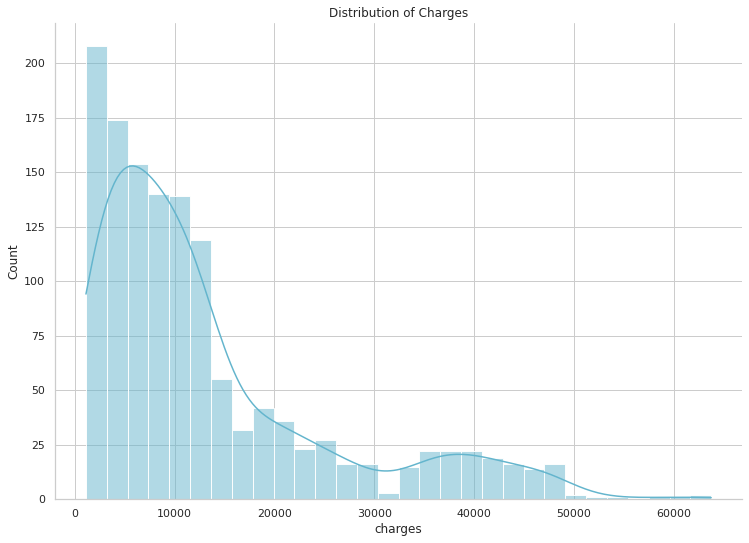

In [ ]:
sns.set(style='whitegrid')
g = sns.displot(df['charges'], kde = True, color = 'c')
plt.title('Distribution of Charges')
g.fig.set_size_inches(12, 8)

Now let's look at the charges by region:

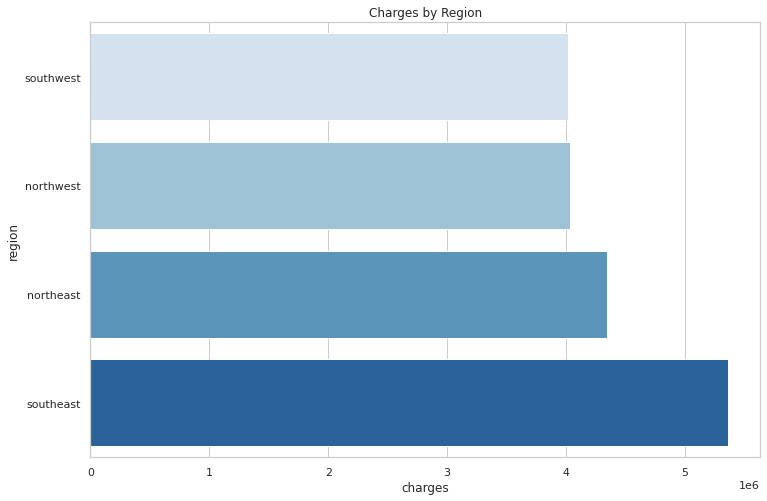

In [ ]:
charges = df['charges'].groupby(df.region).sum().sort_values(ascending = True)
g = sns.barplot(x = charges, y = charges.index, palette='Blues')
plt.title('Charges by Region')
g.figure.set_size_inches(12, 8)

So overall the highest medical charges are in the Southeast and the lowest are in the Southwest.

Taking into account certain factors (sex, smoking, having children) let's see how it changes by region:

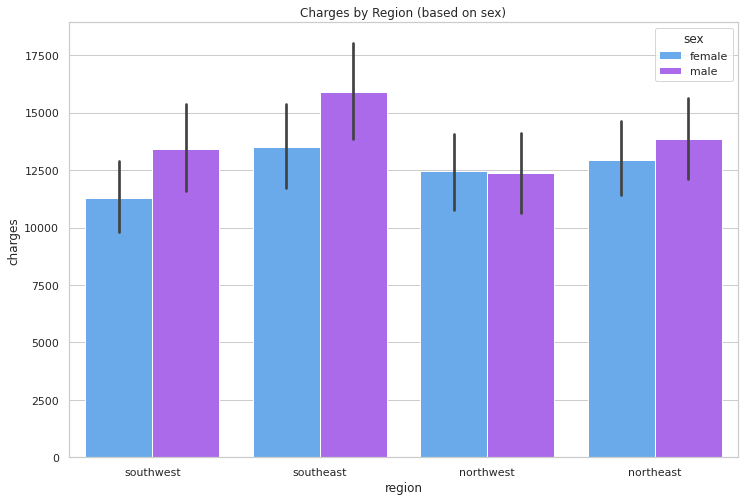

In [ ]:
g = sns.barplot(x='region', y='charges', hue='sex', data=df, palette='cool')
plt.title('Charges by Region (based on sex)')
g.figure.set_size_inches(12, 8)

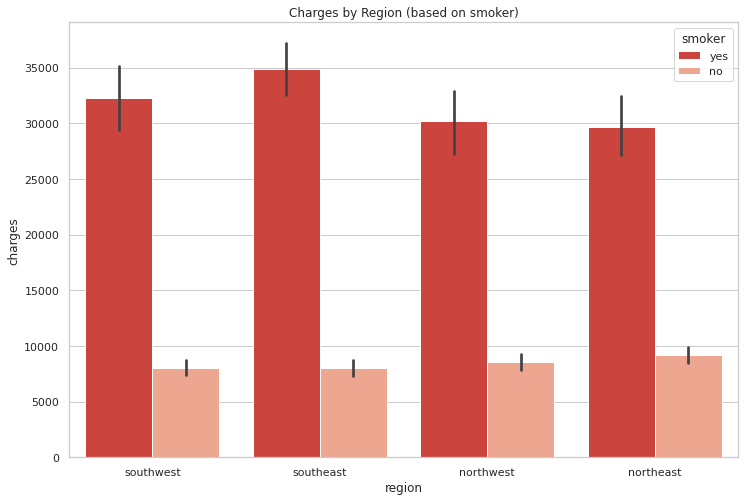

In [ ]:
g = sns.barplot(x = 'region', y = 'charges', hue='smoker', data=df, palette='Reds_r')
plt.title('Charges by Region (based on smoker)')
g.figure.set_size_inches(12, 8)

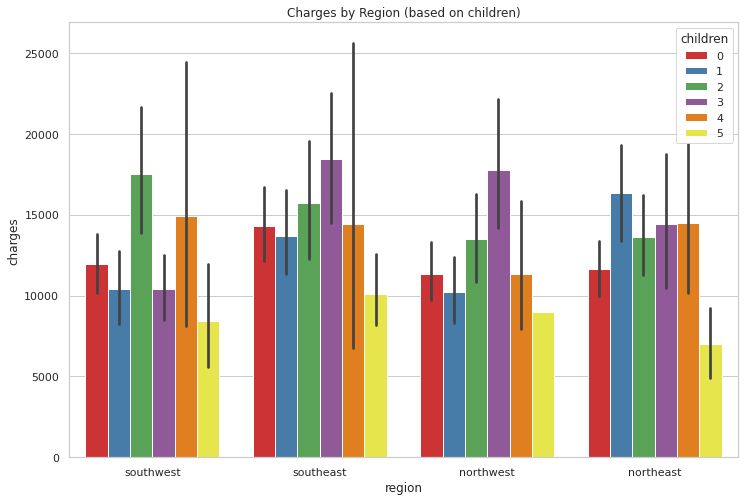

In [ ]:
g = sns.barplot(x='region', y='charges', hue='children', data=df, palette='Set1')
plt.title('Charges by Region (based on children)')
g.figure.set_size_inches(12, 8)

As we can see from these barplots the highest charges due to smoking are still in the Southeast but the lowest are in the Northeast. People in the Southwest generally smoke more than people in the Northeast, but people in the Northeast have higher charges by gender than in the Southwest and Northwest overall. And people with children tend to have higher medical costs overall as well.

Now let's analyze the medical charges by age, bmi and children according to the smoking factor:

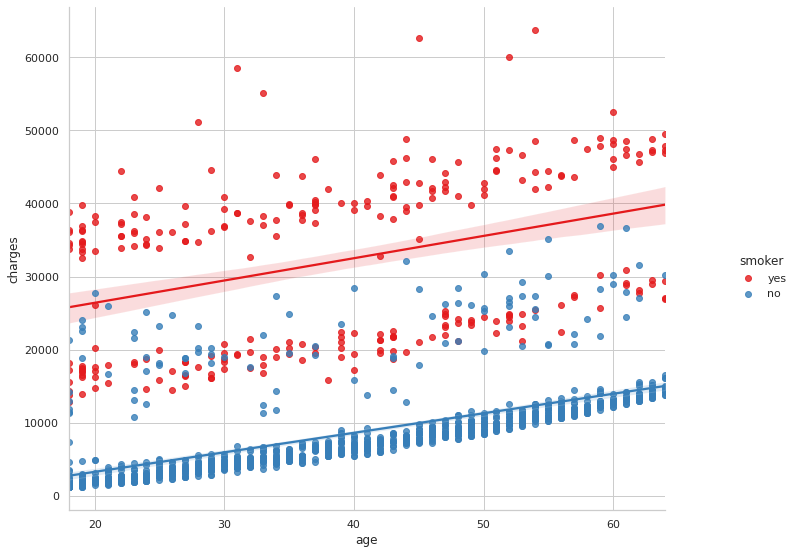

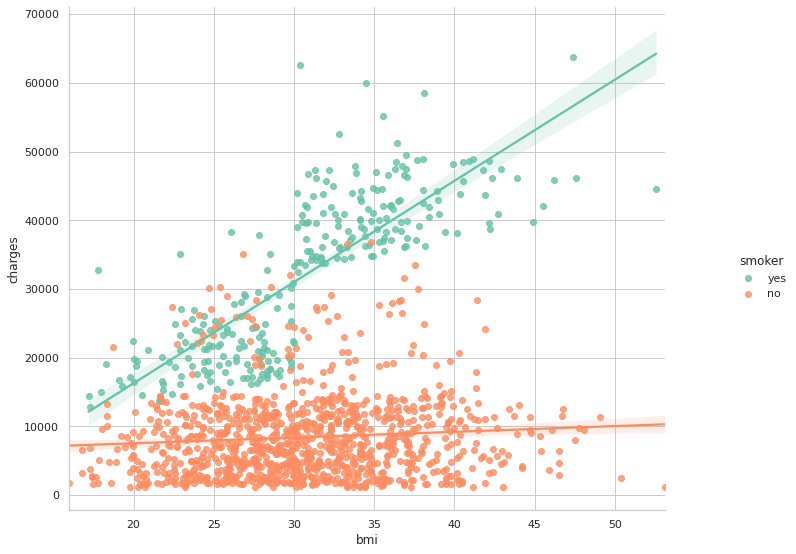

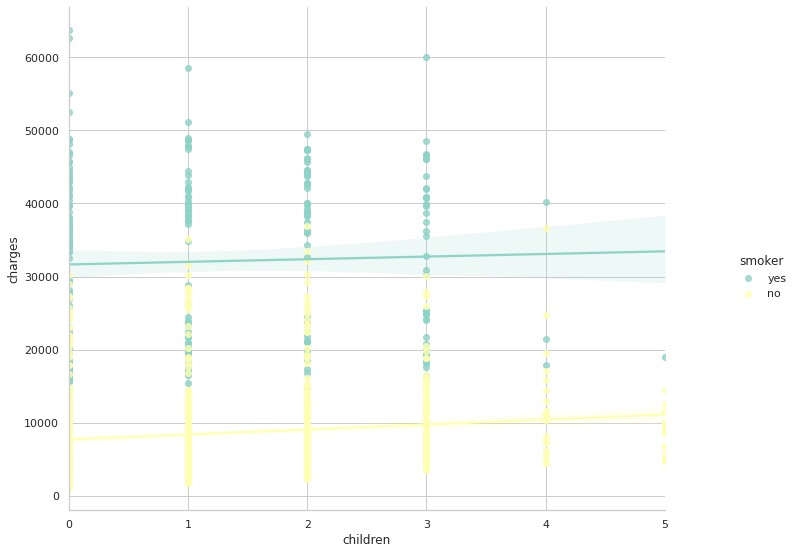

In [ ]:
ax = sns.lmplot(x = 'age', y = 'charges', data=df, hue='smoker', palette='Set1'); ax.fig.set_size_inches(12, 8)
ax = sns.lmplot(x = 'bmi', y = 'charges', data=df, hue='smoker', palette='Set2'); ax.fig.set_size_inches(12, 8)
ax = sns.lmplot(x = 'children', y = 'charges', data=df, hue='smoker', palette='Set3'); ax.fig.set_size_inches(12, 8)

Smoking has the highest impact on medical costs, even though the costs are growing with age, bmi and children.

Also people who have children generally smoke less, which the following violinplots shows too:

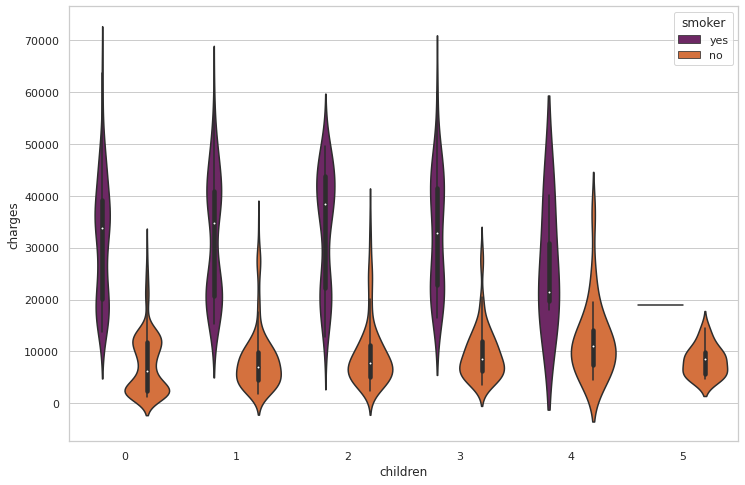

In [ ]:
g = sns.violinplot(x = 'children', y = 'charges', data=df, orient='v', hue='smoker', palette='inferno')
g.figure.set_size_inches(12, 8)

## Quick Preprocessing

In [ ]:
# converting "object" data type into categorical
df[['sex', 'smoker', 'region']] = df[['sex', 'smoker', 'region']].astype('category')
df.dtypes

age            int64
sex         category
bmi          float64
children       int64
smoker      category
region      category
charges      float64
dtype: object

In [ ]:
# converting category labels into numerical using LabelEncoder
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
label.fit(df.sex.drop_duplicates())
df.sex = label.transform(df.sex)
label.fit(df.smoker.drop_duplicates())
df.smoker = label.transform(df.smoker)
label.fit(df.region.drop_duplicates())
df.region = label.transform(df.region)
df.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

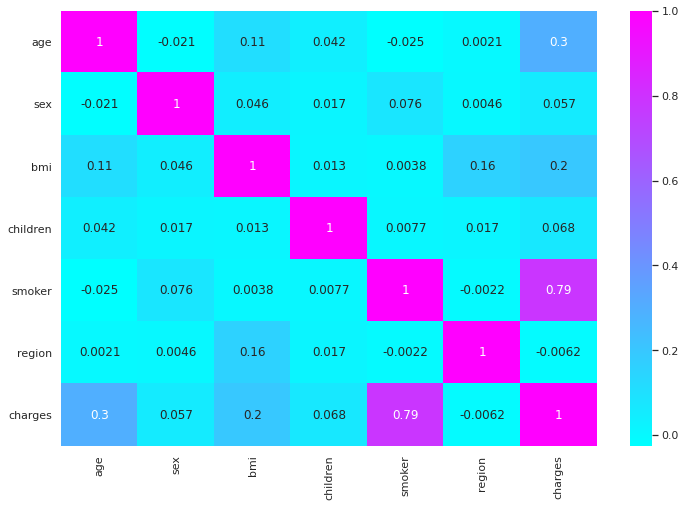

In [ ]:
g = sns.heatmap(df.corr(), annot=True, cmap='cool')
g.figure.set_size_inches(12, 8)

No correlation, except with smoking.

## Linear Regression

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

x = df.drop(['charges'], axis = 1)
y = df['charges']

# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(x_train, y_train)

print("intercept:", model.intercept_)
print("coefficients (model weights):")
print(model.coef_)
print()
print("R2 score (Linear): %.4f%%" % (100 * model.score(x_test, y_test)))

intercept: -11946.606567263048
coefficients (model weights):
[ 2.57056264e+02 -1.87914567e+01  3.35781491e+02  4.25091456e+02
  2.36478181e+04 -2.71284266e+02]

R2 score (Linear): 78.3346%


The result we got is good enough, but we can try to improve it a bit by reducing unimportant features later

## Ridge Regression (L2 Regularization)




In [ ]:
from sklearn.linear_model import Ridge

model_l2 = Ridge(alpha=0.5)
model_l2.fit(x_train, y_train)

print("intercept:", model_l2.intercept_)
print("coefficients (model weights):")
print(model_l2.coef_)
print()
print("R2 score (L2 Regularization): %.4f%%" % (100 * model_l2.score(x_test, y_test)))

intercept: -11930.88610551844
coefficients (model weights):
[ 2.56953795e+02 -1.49035393e+01  3.35787964e+02  4.25317646e+02
  2.35798187e+04 -2.71381009e+02]

R2 score (L2 Regularization): 78.3220%


## Lasso Regression (L1 Regularization)

In [ ]:
from sklearn.linear_model import Lasso

model_l1 = Lasso(alpha=0.2, max_iter=1000, tol=0.0001, selection='cyclic')
model_l1.fit(x_train, y_train)

print("intercept:", model_l1.intercept_)
print("coefficients (model weights):")
print(model_l1.coef_)
print()
print("R2 score (L1 Regularization): %.4f%%" % (100 * model_l1.score(x_test, y_test)))

intercept: -11946.483389454786
coefficients (model weights):
[ 2.57054693e+02 -1.79030972e+01  3.35769642e+02  4.24958233e+02
  2.36465226e+04 -2.71112111e+02]

R2 score (L1 Regularization): 78.3341%


## Polynomial Regression (Non-Linear Models!)

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

x = df.drop(['charges', 'sex', 'region'], axis = 1) # drop categorical
y = df['charges']

# create polynomial features
poly = PolynomialFeatures(degree = 2)
x_poly = poly.fit_transform(x)

x_train, x_test, y_train, y_test = train_test_split(x_poly, y, test_size=0.2, random_state=42)

# train model with new features
model_poly = LinearRegression()
model_poly.fit(x_train, y_train)

y_train_pred = model_poly.predict(x_train)
y_test_pred = model_poly.predict(x_test)

print("intercept:", model_poly.intercept_)
print("coefficients (model weights):")
print(model_poly.coef_)
print()
print("R2 score (Polynomial): %.4f%%" % (100 * model_poly.score(x_test, y_test)))

intercept: -4180.142342057237
coefficients (model weights):
[ 0.00000000e+00 -9.33620988e+01  5.05468577e+02  1.20881558e+03
 -1.01404993e+04  4.05237162e+00  1.13888105e+00 -4.06714756e+00
  7.44693387e+00 -8.71930163e+00  1.16586775e+00  1.44634383e+03
 -1.11858277e+02 -4.41516307e+02 -1.01404993e+04]

R2 score (Polynomial): 86.7043%


In [ ]:
# evaluating the performance of the final algorithm
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Mean Absolute Error:', mean_absolute_error(y_test, y_test_pred))
print('Mean Squared Error:', mean_squared_error(y_test, y_test_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_test, y_test_pred)))

Mean Absolute Error: 2773.5716510212546
Mean Squared Error: 20641401.65533323
Root Mean Squared Error: 4543.280935109916


## Visualizing Predictions

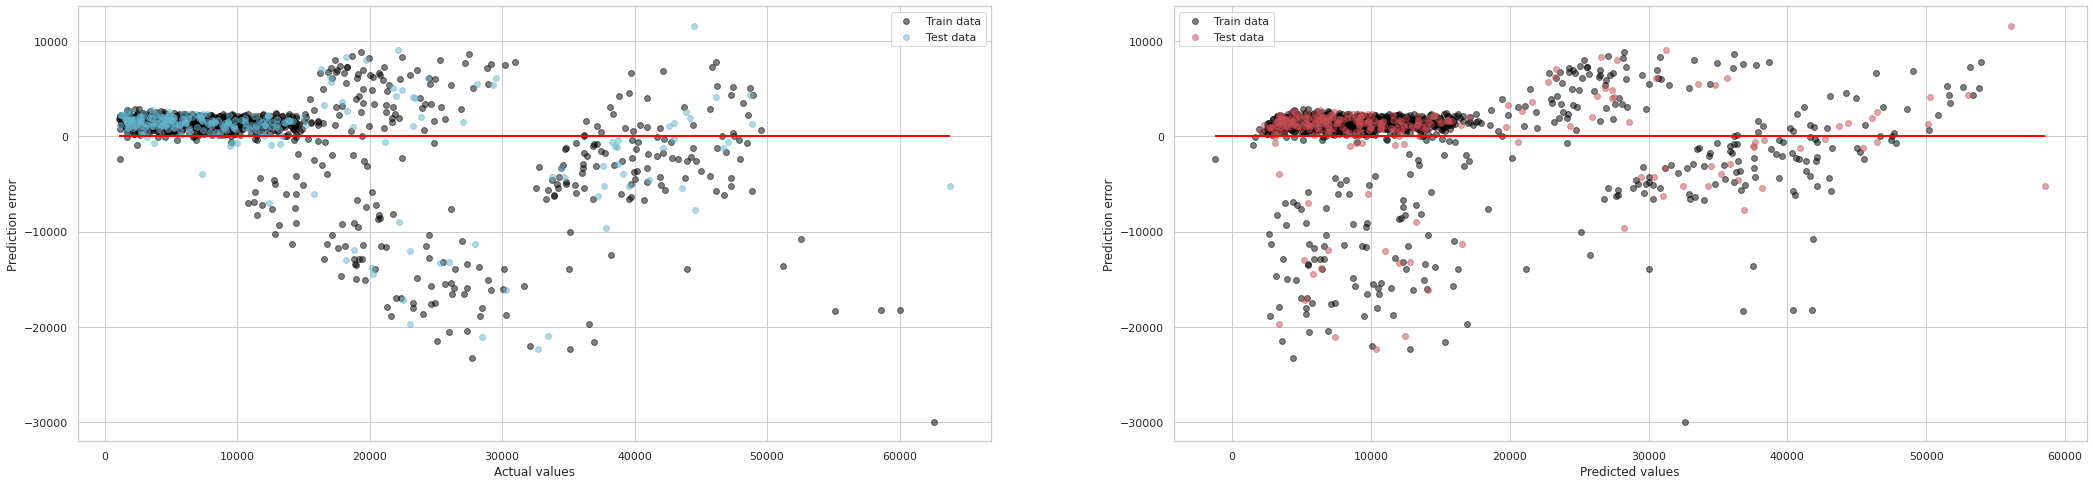

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(36, 8))

ax1.scatter(y_train, y_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
ax1.scatter(y_test, y_test_pred - y_test,
          c = 'c', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')

x_min = min(np.min(y_train), np.min(y_test))
x_max = max(np.max(y_train), np.max(y_test))

ax1.legend()
ax1.hlines(y = 0, xmin = x_min, xmax = x_max, lw = 2, color = 'red')
ax1.set_xlabel('Actual values'); ax1.set_ylabel('Prediction error');

ax2.scatter(y_train_pred, y_train_pred - y_train,
          c = 'black', marker = 'o', s = 35, alpha = 0.5,
          label = 'Train data')
ax2.scatter(y_test_pred, y_test_pred - y_test,
          c = 'r', marker = 'o', s = 35, alpha = 0.5,
          label = 'Test data')
x_min_pred = min(np.min(y_train_pred), np.min(y_test_pred))
x_max_pred = max(np.max(y_train_pred), np.max(y_test_pred))

ax2.legend()
plt.hlines(y = 0, xmin = x_min_pred, xmax = x_max_pred, lw = 2, color = 'red')
ax2.set_xlabel('Predicted values'); ax2.set_ylabel('Prediction error');